In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as scs
import datetime

N = 50  #difference in prices(momentum of stock)
T = 7 #time after which we shuffle our portfolio
R = 0.8 #% of our capital here
M = 5 #number of stocks to hold
F = 0.00005 #brokerage fee

In [4]:
def GetData(nameoffile):
    df = pd.read_csv(f'{nameoffile}')
    df = np.array(df)
    return df

In [16]:
def PartitionData(data):
    DateToIndex = {}
    data_ = [[] for _ in range(data.size//30)]
    
    for i in range(87780):
        if i%30 == 0:
            for j in range(30):
                data_[int(i/30)].append(data[i+j][2])
                data_[int(i/30)].append(data[i+j][3])
                
                DateToIndex[data[i][1]] = []
                DateToIndex[data[i][1]].append(int(i/30))
    
    return data_,DateToIndex
                

In [17]:
print(PartitionData(data))

([['AAPL', 12.964285714285714, 'AXP', 19.33, 'BA', 45.25, 'CAT', 46.91, 'CSCO', 16.96, 'CVX', 76.52, 'DD', 46.23462346234624, 'DIS', 23.92, 'GS', 86.76, 'HD', 24.13, 'IBM', 87.37, 'INTC', 15.2, 'JNJ', 60.65, 'JPM', 31.35, 'KO', 22.95, 'MCD', 63.75, 'MMM', 59.19, 'MRK', 31.0, 'MSFT', 20.33, 'NKE', 13.265, 'PFE', 18.27, 'PG', 62.8, 'RTX', 54.95, 'TRV', 45.2, 'UNH', 27.59, 'V', 13.36, 'VZ', 34.64, 'WBA', 25.55, 'WMT', 57.18, 'XOM', 81.64], ['AAPL', 13.51142857142857, 'AXP', 19.95, 'BA', 46.17, 'CAT', 46.08, 'CSCO', 17.11, 'CVX', 76.66, 'DD', 45.15451545154516, 'DIS', 23.5, 'GS', 88.78, 'HD', 24.71, 'IBM', 86.82, 'INTC', 14.91, 'JNJ', 60.05, 'JPM', 29.25, 'KO', 22.72, 'MCD', 63.56, 'MMM', 58.5, 'MRK', 30.53, 'MSFT', 20.52, 'NKE', 13.36, 'PFE', 18.16, 'PG', 62.35, 'RTX', 54.3, 'TRV', 44.53, 'UNH', 27.14, 'V', 13.455, 'VZ', 32.48, 'WBA', 26.84, 'WMT', 56.52, 'XOM', 81.63], ['AAPL', 13.288571428571428, 'AXP', 21.07, 'BA', 46.31, 'CAT', 45.8, 'CSCO', 17.79, 'CVX', 77.35, 'DD', 48.1548154815481

In [6]:
def GetMomentumBasedPriority(data_,datetoindex,today,Ndays):
    Ndaysago = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) - datetime.timedelta(days=Ndays)
    
    req_date = Ndaysago.strftime("%Y%m%d")
    
    momentum = []
    prices = []
    
    for i in range(30):
        prices.append(data_[datetoindex[int(today)][0]][2*i+1])
    
    if int(req_date) not in datetoindex:
        Ndaysago = Ndaysago + datetime.timedelta(days=1)
        req_date = (Ndaysago).strftime("%Y%m%d")
        while(int(req_date) not in datetoindex):
            Ndaysago = Ndaysago + datetime.timedelta(days=1)
            req_date = (Ndaysago).strftime("%Y%m%d")
            if int(req_date) in datetoindex:
                break
        index_today = datetoindex[int(today)][0]
        index_req = datetoindex[int(req_date)][0]
        
        for i in range(30):
            total = 0
            moment = data_[index_today][2*i+1]-data_[index_req][2*i+1]
            for j in range(index_req,index_today+1):
                total+=data_[j][2*i+1]
            total = total/(index_today-index_req+1)
            momentum.append(moment/total)
    else:
        index_today = datetoindex[int(today)][0]
        index_req = datetoindex[int(req_date)][0]
        
        for i in range(30):
            moment = data_[index_today][2*i+1]-data_[index_req][2*i+1] 
            total = 0
            
            for j in range(index_req,index_today+1):
                total+=data_[j][2*i+1]
            total = total/(index_today-index_req+1)
            momentum.append(moment/total)
            
    return momentum,prices
    

In [7]:
def GetShares(data_,momentum,prices,balance):
    for i in range(30):
        if momentum[i]<0:
            momentum[i]=0
    momentum = np.array(momentum)
    
    Hold = False
    
    if np.all(momentum == 0):
        Hold = True
    
    else:
        norm_weights = momentum/np.sum(momentum)
        shares = []

        for i in range(30):
            share_num = (balance*norm_weights[i])/prices[i]
            shares.append(int(share_num))
        return shares, Hold
    
    return None,Hold

In [8]:
class Portfolio:
    def __init__(self,init_balance,curr_balance,stocks,prices):
        self.init_balance = init_balance
        self.curr_balance = curr_balance
        self.stocks = stocks #what you have 
        self.prices = prices #today's prices
        
    def SellStock(self,index):
        self.curr_balance += self.stocks[index]*self.prices[index]*(1-F)
        self.stocks[index] = 0
        
    def BuyStock(self,index,number):
        self.stocks[index] += number
        self.curr_balance -= number*self.prices[index]*(1+F)
    
    def CalcNetWorth(self):
        new_balance = 0
        for i in range(30):
            new_balance += self.stocks[i]*self.prices[i]
        return new_balance + self.curr_balance
    
    def ChangePricesTo(self,newPrices):
        self.prices = newPrices
     
    def RebalancePortfolio(self,new_momentum):
        shares, Hold = GetShares(data_,new_momentum,self.prices,self.curr_balance)
        if(Hold):
            None
        else:
            if not(np.all(self.stocks==0)):
                for i in range(30):
                    self.SellStock(i)
            for i in range(30):
                self.BuyStock(i,shares[i])
    def Reset(self):
        self.curr_balance = 200000

In [9]:
data  = GetData('DATA.csv')
data_,DTI = PartitionData(data)

Po = Portfolio(200000,200000,np.zeros(30),np.zeros(30))

NetWorth = [np.zeros(2926-l) for l in range(5,50)]

for l in range(5,50):
    Po.Reset()
    for i in range(l,2926):
        Nthdate = data[i*30][1]
        momentum,prices = GetMomentumBasedPriority(data_,DTI,f'{Nthdate}',l)
        Po.ChangePricesTo(prices)
        Po.RebalancePortfolio(momentum)
        NetWorth[l-5][i-l] = Po.CalcNetWorth()
    

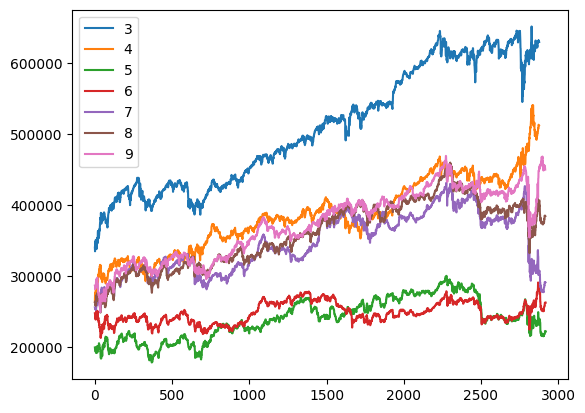

In [10]:
for i in range(3,10):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()

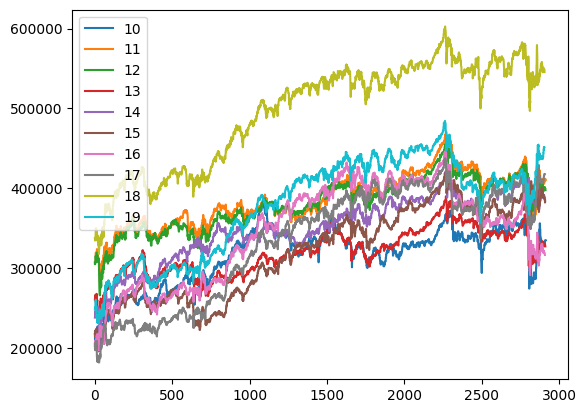

In [11]:
for i in range(10,20):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()

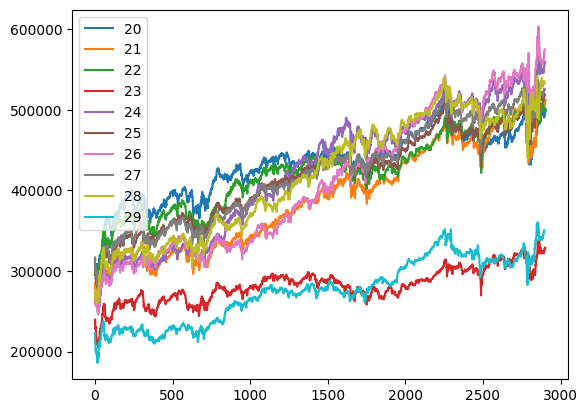

In [12]:
for i in range(20,30):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()

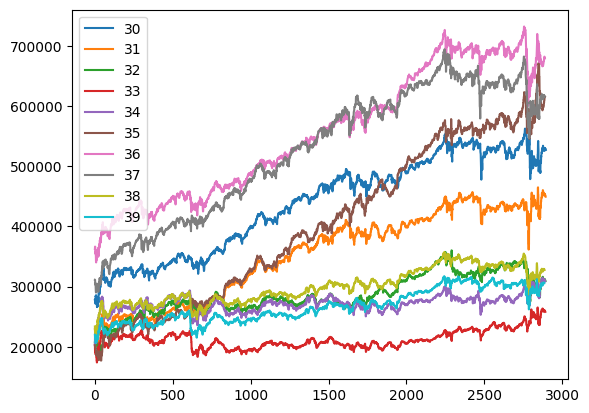

In [13]:
for i in range(30,40):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()

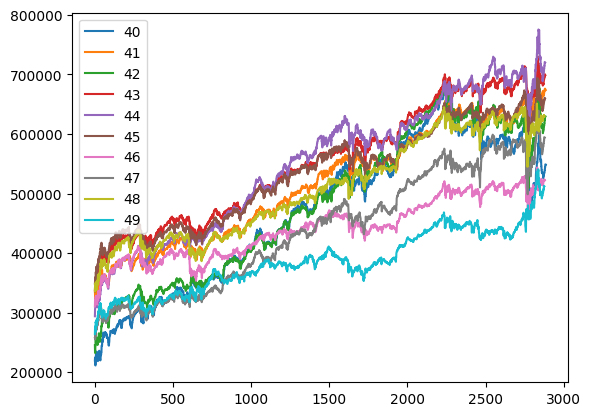

In [14]:
for i in range(40,50):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()

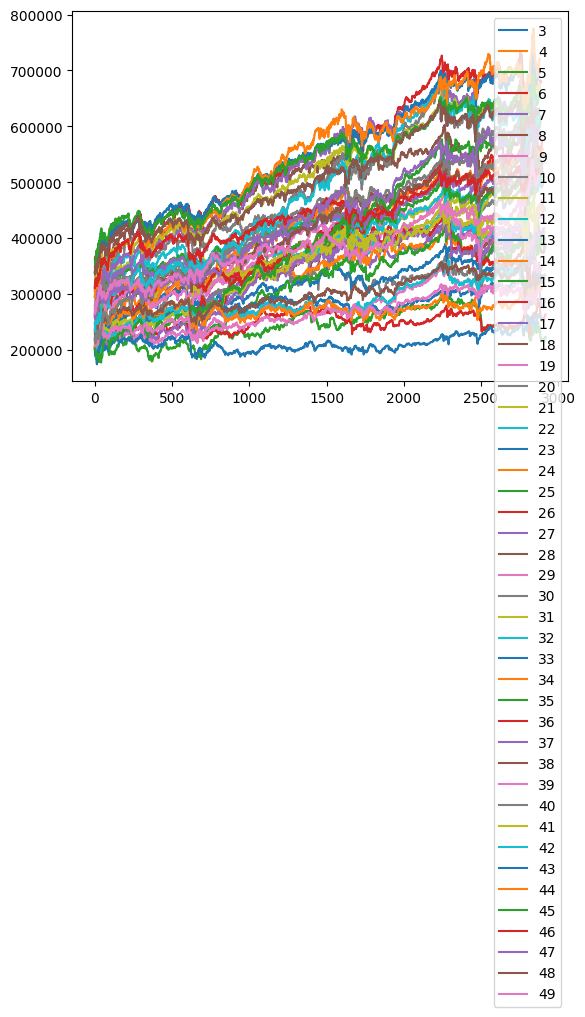

In [15]:
for i in range(3,50):
    string = str(i)
    plt.plot(NetWorth[i-5],label=string)
plt.legend()
plt.show()